# HCM rates by Clinvar and Risk 
##### Updated 07/02/2024
##### Selin Kubali

#### Goal:
Graph HCM rates for high-risk and low-risk patients in different Clinvar categories across all genes with models.
#### Required inputs
Lifelines files - Stored in */selected_genes/hcm/cox_model_data*. 

Variant data files - Stored in */selected_genes/hcm/variant_files*.

Clinvar data - Stored in */selected_genes/hcm/csv_files/variant_summary.txt*

##### Load packages

In [ ]:
!pip install lifelines --quiet --root-user-action=ignore
!pip install scikit-learn --quiet --root-user-action=ignore
!pip install matplotlib --quiet --root-user-action=ignore
!pip install statsmodels --quiet --root-user-action=ignore

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import warnings
from lifelines import CoxPHFitter
from sklearn.model_selection import KFold
import sklearn.metrics as metrics



plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica') 
plt.rcParams.update({'font.size': 14})
warnings.filterwarnings("ignore")

variant_summary_file = 'variant_summary.txt'

In [ ]:
def download_gene(variant_summary_path = '/selected_genes/hcm/csv_files/', variant_summary_name = variant_summary_file):
    variant_summary_file_name = variant_summary_file + '.gz'
    variant_summary_path = variant_summary_path + variant_summary_file_name
    !dx download $variant_summary_path
    !gzip -d $variant_summary_file_name
download_gene()

#### Generate hazard scores

In [281]:
def cross_val(gene, only_variant_info = False, dir_path_variant="selected_genes/hcm/variant_files", dir_path_cox = "selected_genes/hcm/cox_model_data"):
        """ Load variant data, individual patient data, and clinvar data. Runs cross-validation on individual patient data to predict risk of developing HCM. Cleans and joins files and returns a file with individual patient data, individual patient hazard scores, and clinvar pathogenicity data.
        """


        cph = CoxPHFitter(penalizer = 0.001)
        
        
        
        # load lifelines file


        lifelines_data = pd.read_csv(f'/mnt/project/selected_genes/hcm/{dir_path_cox}/{gene}_with_generated_data.csv', 
                                     dtype = {'duration':'float', 'is_HCM':'boolean', 'sex':'boolean',
                                              'is_family_hist':'boolean', 'is_AF':'boolean',
                                              'is_HTN': 'boolean', 'am_pathogenicity':'float'})
        
        lifelines_data['prs_score'] = (lifelines_data['prs_score'] - lifelines_data['prs_score'].min()) / (lifelines_data['prs_score'].max() - lifelines_data['prs_score'].min())     
        lifelines_data['am_pathogenicity'] = (lifelines_data['am_pathogenicity'] - lifelines_data['am_pathogenicity'].min()) / (lifelines_data['am_pathogenicity'].max() - lifelines_data['am_pathogenicity'].min())     
        lifelines_data['cadd_raw_score'] = (lifelines_data['cadd_raw_score'] - lifelines_data['cadd_raw_score'].min()) / (lifelines_data['cadd_raw_score'].max() - lifelines_data['cadd_raw_score'].min())     
        lifelines_data['phylop'] = (lifelines_data['phylop'] - lifelines_data['phylop'].min()) / (lifelines_data['phylop'].max() - lifelines_data['phylop'].min())     
        lifelines_data['faf_max'] = (lifelines_data['faf_max'] - lifelines_data['faf_max'].min()) / (lifelines_data['faf_max'].max() - lifelines_data['faf_max'].min())     

        no_variant = lifelines_data[~lifelines_data['Consequence'].isin(['synonymous_variant','deleterious','missense_variant'])]
        hcm_no_variant = no_variant['is_HCM'].sum()
        total_no_variant = no_variant['is_HCM'].count()

        lifelines_data = lifelines_data[lifelines_data['Consequence'].isin(['synonymous_variant','deleterious','missense_variant'])]
        lifelines_data.loc[lifelines_data['Consequence'] == 'deleterious', 'am_pathogenicity'] = 1
        lifelines_data.loc[lifelines_data['Consequence'] == 'synonymous_variant', 'am_pathogenicity'] = 0
        


        if 'revel_max' in lifelines_data.columns:
            variant_level_features = ['am_pathogenicity','cadd_raw_score','faf_max','phylop','spliceai_ds_max','revel_max']
            lifelines_data['revel_max'] = (lifelines_data['revel_max'] - lifelines_data['revel_max'].min()) / (lifelines_data['revel_max'].max() - lifelines_data['revel_max'].min())     

        else:
            variant_level_features = ['am_pathogenicity','cadd_raw_score','faf_max','phylop','spliceai_ds_max']

        demographic_level_features = ['is_HTN', 'is_AF', 'prs_score', 'sex', 'is_family_hist']
        if only_variant_info == True:
            lifelines_data = lifelines_data[['Name', 'Carrier', 'duration', 'is_HCM'] + variant_level_features]

        else:
            lifelines_data = lifelines_data[['Name', 'Carrier', 'duration', 'is_HCM'] + variant_level_features + demographic_level_features]

    

        variant_data = pd.read_csv(f'/mnt/project/{dir_path_variant}/{gene}_variants.csv')

        variant_data_name = variant_data[['Name']]
        variant_data_name= variant_data_name.dropna()

        # set lifelines data index to variant data index
        variant_data_name['var_index'] = variant_data_name.index
        lifelines_data = variant_data_name.merge(lifelines_data, how="outer")
        lifelines_data.set_index("var_index")
        lifelines_data=lifelines_data.dropna()
        lifelines_data = lifelines_data.drop_duplicates(subset=['Carrier'])


        # load, clean, and merge clinvar information
        clinvar_df = pd.read_csv(variant_summary_file, sep = '\t', dtype = {'Chromosome':'str'})
        clinvar_df = clinvar_df[clinvar_df['Assembly'] == 'GRCh38']
        clinvar_df = clinvar_df.rename(columns={"Chromosome": "Chrom", "Start": "Pos", "ReferenceAlleleVCF": "Ref", "AlternateAlleleVCF": "Alt"})
        clinvar_df = clinvar_df[["Name", "Chrom", "Pos", "Ref", "Alt", "ClinicalSignificance"]]
        clinvar_variant_df = pd.merge(variant_data, clinvar_df, how = 'left', on = ['Pos', 'Ref', 'Alt'])
        clinvar_variant_df = clinvar_variant_df.rename(columns={"Name_x": "Name"})
        clinvar_variant_df = clinvar_variant_df[["Name", "ClinicalSignificance"]]
        lifelines_data = pd.merge(lifelines_data,clinvar_variant_df, how="left", on = ['Name'])
        lifelines_data = lifelines_data.drop_duplicates(subset=['Carrier'])




        # cross validation: split up phenotypic data file based on variant file index
        kf = KFold(n_splits=5, shuffle=True, random_state=4)
        testing_set = []
        for train_idx, test_idx in kf.split(variant_data):




                train = lifelines_data[lifelines_data['var_index'].isin(train_idx)]
                test = lifelines_data[lifelines_data['var_index'].isin(test_idx)]
                train = train.drop(['var_index'], axis=1)
                test = test.drop(['var_index'], axis=1)


                # fit CPH and add hazard scores
                if only_variant_info == True:
                    cph.fit(train, duration_col="duration", event_col="is_HCM", fit_options = {"step_size":0.1}, formula = variant_level_features)
                else:
                    cph.fit(train, duration_col="duration", event_col="is_HCM", fit_options = {"step_size":0.1}, formula = variant_level_features + demographic_level_features)

                hazard_scores_fold = cph.predict_partial_hazard(test)
                test['hazard'] = hazard_scores_fold
                testing_set.append(test)




        # create new lifelines_data df by joining all testing sets
        lifelines_data = pd.concat([df for idx, df in enumerate(testing_set)]) 

        return lifelines_data, hcm_no_variant, total_no_variant



#### Calculate and split on threshold

In [ ]:
def find_threshold_vals(gene, only_variant_info = False):
    
    """ Runs CoxPH cross-validation with the chosen threshold for a gene."""

    if only_variant_info == True:
        print("Model with only variant-level features")
        lifelines_data, hcm_no_variant, total_no_variant = cross_val(gene, only_variant_info = True)
    else:
        print("Model with all features")
        lifelines_data, hcm_no_variant, total_no_variant = cross_val(gene)

    # grouping and renaming Clinvar variants
    lifelines_data = lifelines_data[lifelines_data['ClinicalSignificance'] != 'not provided']
    lifelines_data.loc[(lifelines_data['ClinicalSignificance'].isin(['Pathogenic', 'Pathogenic/Likely pathogenic', 'Likely pathogenic']), 'ClinicalSignificance')] = 'P/LP'
    lifelines_data.loc[(lifelines_data['ClinicalSignificance'].isin(['Benign', 'Likely benign', 'Benign/Likely benign']), 'ClinicalSignificance')] = 'B/LB'
    lifelines_data.loc[(lifelines_data['ClinicalSignificance'].isin(['Conflicting classifications of pathogenicity']), 'ClinicalSignificance')] = 'Conflicting'
    lifelines_data.loc[(lifelines_data['ClinicalSignificance'].isin(['Uncertain significance']), 'ClinicalSignificance')] = 'Uncertain'

    lifelines_data['is_HCM'] = lifelines_data['is_HCM'].astype('int64')
    lifelines_data_synonymous = lifelines_data[(lifelines_data['am_pathogenicity'] == 0)]
    lifelines_data = lifelines_data[(lifelines_data['am_pathogenicity'] != 0)]

    # threshold calculation
    fpr, tpr, thresholds = metrics.roc_curve(lifelines_data['is_HCM'], lifelines_data['hazard'], pos_label = 1)
    roc_auc = metrics.auc(fpr, tpr)
    lifelines_data_vus = lifelines_data[~lifelines_data['ClinicalSignificance'].isin(['B/LB', 'P/LP'])]
    vus_hazard_min = lifelines_data_vus[lifelines_data_vus['is_HCM'] == 1]['hazard'].min()
    vus_hazard_max = lifelines_data_vus[lifelines_data_vus['is_HCM'] == 1]['hazard'].max()
    min_index = np.argmin(np.abs(np.array(thresholds)-vus_hazard_min)) # vus min should be larger than any other variable
    max_index = np.argmin(np.abs(np.array(thresholds)-vus_hazard_max))
    tpr_limited = tpr[max_index:min_index]
    fpr_limited = fpr[max_index:min_index]
    thresholds = thresholds[max_index:min_index]
    optimal_idx = np.argmax(tpr_limited - fpr_limited)
    hazard = thresholds[optimal_idx]
    
    
    # splitting dataset on risk
    lifelines_data['Risk'] = np.where(lifelines_data['hazard'] > hazard, 'High', 'Low')
    lifelines_data_synonymous['Risk'] = np.where(lifelines_data_synonymous['hazard'] > hazard, 'High', 'Low')
    lifelines_data_synonymous['ClinicalSignificance'] = 'Syn'
    lifelines_data = pd.concat([lifelines_data, lifelines_data_synonymous])

    # grouping by risk and clinical significance
    hcm_count = pd.DataFrame(lifelines_data.groupby(['ClinicalSignificance','Risk'])['is_HCM'].sum()).reset_index().pivot(columns = 'Risk', index = 'ClinicalSignificance', values = 'is_HCM')
    total_count = pd.DataFrame(lifelines_data.groupby(['ClinicalSignificance','Risk'])['is_HCM'].count()).reset_index().pivot(columns = 'Risk', index = 'ClinicalSignificance', values = 'is_HCM')
    
    return hcm_count,total_count,hcm_no_variant, total_no_variant


##### Loading and combining data for all genes

In [ ]:
# initialize dfs
hcm_count, total_count = [pd.DataFrame({
    'ClinicalSignificance': ['B/LB', 'Conflicting', 'P/LP', 'Uncertain', 'Syn'],
    'High': [0]*5,
    'Low': [0]*5}).set_index('ClinicalSignificance')]*2
hcm_no_variant, total_no_variant = [0]*2

for gene in ['ACTN2', 'ALPK3', 'FLNC', 'MYBPC3', 'MYH6', 'MYH7', 'MYL2', 'PTPN11', 'TNNT2']:
    print(gene)
    hcm, total, hcm_none, total_none  = find_threshold_vals(gene)
    hcm_count, total_count, hcm_no_variant, total_no_variant = hcm + hcm_count, total + total_count, hcm_none + hcm_no_variant, total_none + total_no_variant
    hcm_count.fillna(value=0, inplace=True)
    total_count.fillna(value=0, inplace=True)
    
hcm_rates = hcm_count / total_count #calculate rates
no_variant = hcm_no_variant/total_no_variant
no_variant = pd.DataFrame({'High': no_variant, 'Low': no_variant}, index = ['No variant'])
hcm_rates = pd.concat([hcm_rates, no_variant])

Text(0.5, 1.0, 'HCM rates by risk and Clinvar groups')

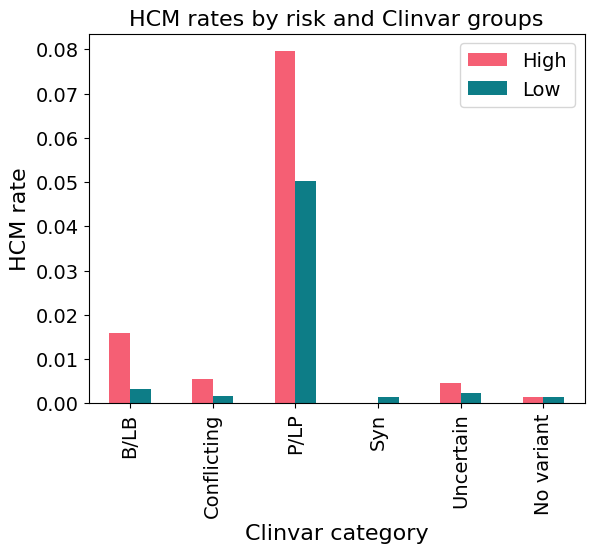

In [316]:
ax = hcm_rates.plot(kind='bar', color=['#f55f74', '#0d7d87'])
plt.xlabel("Clinvar category", fontdict={'fontsize':16})
plt.ylabel("HCM rate", fontdict={'fontsize':16})
plt.title("HCM rates by risk and Clinvar groups", fontdict={'fontsize':16})